# Stock Analysis

El objetivo es describir las caracteristicas del asset operado para entender mejor a que me estoy exponiendo, en terminos de riesgo/retorno, entre otras cosas.
Para esto definimos cuatro dimensiones descriptivas:

* dimensión estadística
* dimensíon de dependencia
* dimensión técnico 
* dimensión fundamental


****
## DIMENSION ESTADISTICA

In [2]:
import numpy as np, pandas as pd
import matplotlib as mpl, seaborn as sns
import os, pickle, requests

from matplotlib import pyplot as plt
from scipy import stats

In [3]:
def getPrice(symbol):
    """
    Historical Daily Prices
    Dado un activo (symbol), retorna unicamente su closing price historico (máx 40 years)
    Return: daily dataframe (close)
    """        
    try:
        url='https://financialmodelingprep.com/api/v3/historical-price-full/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p= {'serietype' : 'line','apikey': api_key}
        r=requests.get(url,params=p)
        js=r.json()
        df=pd.DataFrame(js['historical'])
        df.set_index('date',inplace=True)
        df.index=pd.to_datetime(df.index)
        df.rename(columns={'close':'price'},inplace=True)
        df.sort_values('date',ascending=True, inplace=True)
        return df

    except:
        print(symbol,' Historical daily prices not found')

In [46]:
# SQM - ALB - LTHM - LAC - PLL (5 stocks para jugar al Litio,CF, May 2021)
# TLRY - CTRM - FCEL - NOK - APHA (CF,May 2021)
# CPLP-NMM-PLG- MAG /SU/CRM/FNV/SLV/LQD/CCJ
# ['ARCH','BTU','TDW','HLX','RIG','NOV','RES','CNX','FRO','SBLK','NMM','GOGL','CMRE','GLNG','PAM','CRESY','IPI','MOS','EDN','VIST','FCX','TRQ','NXE','DNN','UUU']

ticker='RIG' 
stock=getPrice(ticker)
#stock=stock.loc[stock.index>'1995']

In [47]:
# def calculos(ticker)
stock['retorno'] = stock['price'].pct_change() # idem b[1:]/b[:-1]-1
stock['cagr']=((stock.retorno+1).cumprod()-1)
stock['volatilidad'] = stock['retorno'].rolling(250).std() * 250**0.5
stock['drawdown']=(stock['retorno']+1).cumprod() / (stock['retorno']+1).cumprod().cummax()-1

stock['mes']=stock.index.month
stock['year']=stock.index.year
stock['fecha']=stock.index.values
stock['factor']=stock.price.pct_change()+1

agrupados=pd.DataFrame()
agrupados['yield']=stock.factor.groupby([stock.fecha.dt.year,stock.fecha.dt.month]).prod()
agrupados['yield']=(agrupados['yield']-1)*100
agrupados['año'] = agrupados.index.get_level_values(0)
agrupados['mes'] = agrupados.index.get_level_values(1)
rendimientos=agrupados.pivot('año','mes','yield')

agrupa=pd.DataFrame()
agrupa['dd']=stock.drawdown.groupby([stock.fecha.dt.year,stock.fecha.dt.month]).min()*100
agrupa['año'] = agrupa.index.get_level_values(0)
agrupa['mes'] = agrupa.index.get_level_values(1)
rendi=agrupa.pivot('año','mes','dd')

<AxesSubplot:xlabel='mes', ylabel='año'>

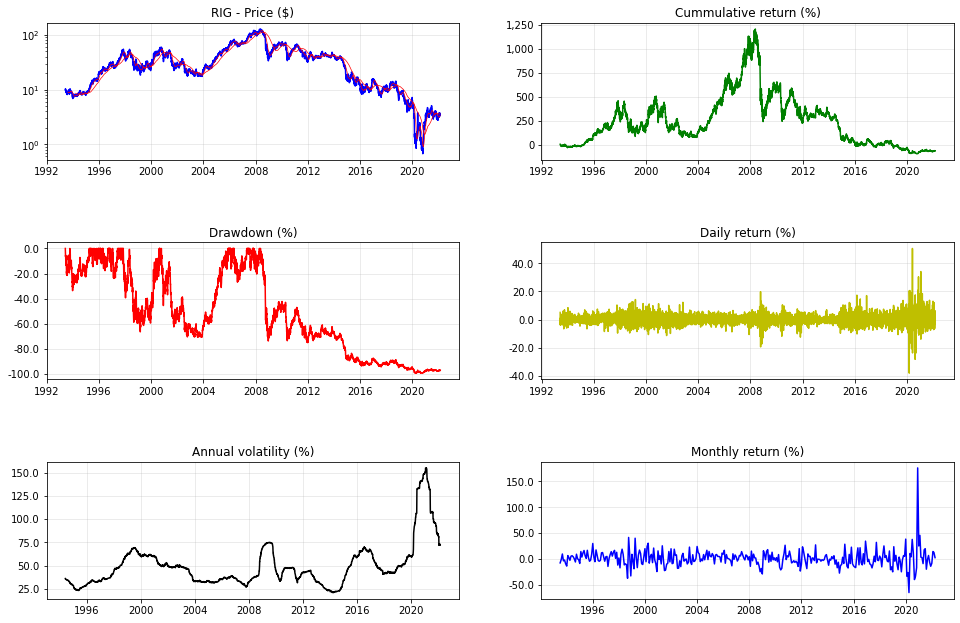

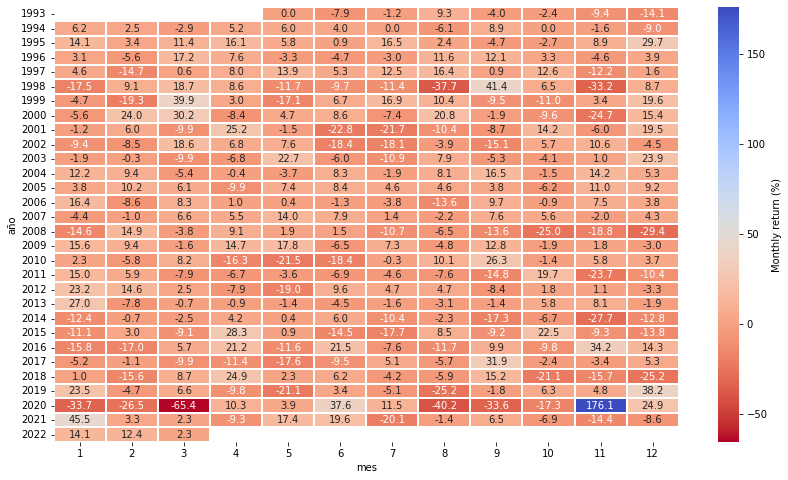

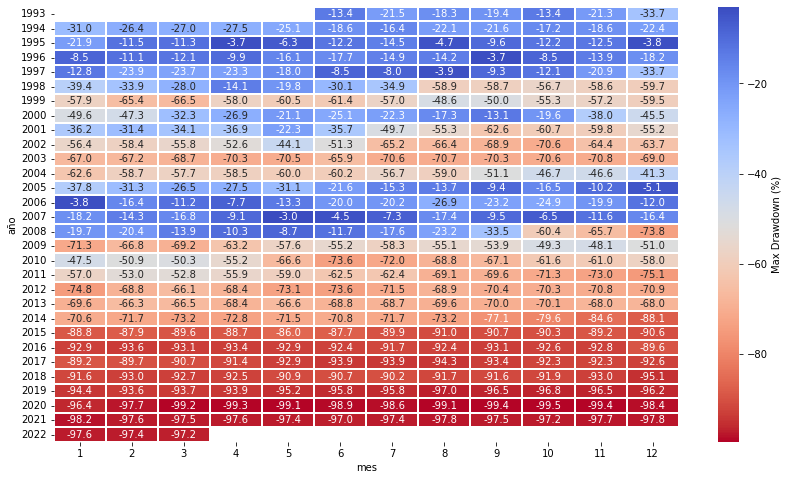

In [48]:
# PLOT PANEL GENERAL

fig,ax =plt.subplots(figsize=(14,8),nrows=3,ncols=2)
fig.subplots_adjust(hspace=0.6,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - Price ($)')
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][0].set_yscale('log')
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(stock.price,'b-')
ax[0][0].plot(stock.price.rolling(50).mean(),'r-',lw=0.7)
ax[0][0].plot(stock.price.rolling(200).mean(),'r-',lw=0.7)

ax[0][1].title.set_text('Cummulative return (%)')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][1].grid('True',alpha=0.3)
ax[0][1].plot(stock.cagr*100,'g-')

ax[1][0].title.set_text('Drawdown (%)')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(stock.drawdown*100,'r-')

ax[1][1].title.set_text('Daily return (%)')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(stock.retorno*100,'y-')

ax[2][0].title.set_text('Annual volatility (%)')
ax[2][0].grid('True',alpha=0.3)
ax[2][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[2][0].plot(stock.volatilidad*100,'k-')
#ax[2][0].axhline(stock.volatilidad.mean(),ls='--',color='r')

ax[2][1].title.set_text('Monthly return (%)')
ax[2][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[2][1].grid('True',alpha=0.3)
ax[2][1].plot(stock.price.resample('M').ffill().pct_change()*100,'b-')

f,ax=plt.subplots(figsize=(14,8))
sns.heatmap(rendimientos,annot=True,fmt='.1f',linewidths=.1,cmap='coolwarm_r',ax=ax,cbar_kws={'label': 'Monthly return (%)'}) #coolwarm/rocket/mako/icefire

f,ax=plt.subplots(figsize=(14,8))
sns.heatmap(rendi,annot=True,fmt='.1f',linewidths=.1,cmap='coolwarm_r',ax=ax,cbar_kws={'label': 'Max Drawdown (%)'}) #coolwarm/rocket/mako/icefire

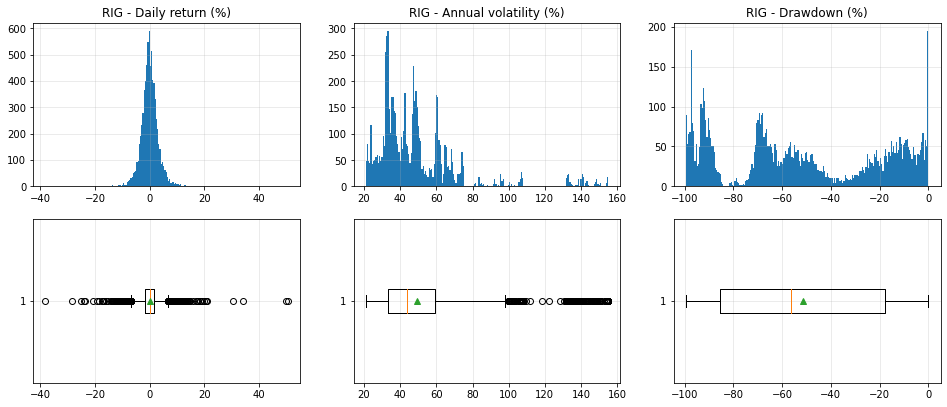

In [49]:
# PLOT PANEL PARTICULAR

fig,ax =plt.subplots(figsize=(14,5),nrows=2,ncols=3)
fig.subplots_adjust(hspace=0.2,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - Daily return (%)')
ax[0][0].hist(stock.retorno.dropna()*100,bins=200)
ax[1][0].boxplot(stock.retorno.dropna()*100,vert=False,showmeans=True,showfliers=True)
ax[0][0].grid('True',alpha=0.3)
ax[1][0].grid('True',alpha=0.3)

ax[0][1].title.set_text(ticker + ' - Annual volatility (%)')
ax[0][1].hist(stock.volatilidad.dropna()*100,bins=200)
ax[1][1].boxplot(stock.volatilidad.dropna()*100,vert=False,showmeans=True,showfliers=True)
ax[0][1].grid('True',alpha=0.3)
ax[1][1].grid('True',alpha=0.3)

ax[0][2].title.set_text(ticker + ' - Drawdown (%)')
ax[0][2].hist(stock.drawdown.dropna()*100,bins=200)
ax[1][2].boxplot(stock.drawdown.dropna()*100,vert=False,showmeans=True,showfliers=True)
ax[0][2].grid('True',alpha=0.3)
ax[1][2].grid('True',alpha=0.3)

In [50]:
print(ticker + ' - Statistics\n')
lista=[stock.retorno.dropna()*100,stock.volatilidad.dropna()*100,stock.drawdown.dropna()*100]
tabla=pd.DataFrame(index=['Size','Min','Max','Mean','Std','Skew','Kurtosis'])
j=0
for i in list(['Daily return (%)','Annual volatility','Drawdown (%)']):
    data=lista[j]
    tabla[i]=[stats.describe(lista[j])[0],stats.describe(lista[j])[1][0],stats.describe(lista[j])[1][1],stats.describe(lista[j])[2],
    np.sqrt(stats.describe(lista[j])[3]),stats.describe(lista[j])[4],stats.describe(lista[j])[5]]
    j+=1

tabla.style.format('{:20,.3f}')

RIG - Statistics



,Daily return (%),Annual volatility,Drawdown (%)
Size,"7,241.000","6,992.000","7,241.000"
Min,-38.115,20.928,-99.478
Max,50.602,154.984,0.000
Mean,0.045,49.209,-51.502
Std,3.457,23.833,32.617
Skew,0.905,2.236,0.110
Kurtosis,20.729,6.023,-1.356


****
## DIMENSION DE DEPENDENCIA

### Variables macro

https://fred.stlouisfed.org/

* VIX (CBOE Volatility Index: VIX (VIXCLS))
* US Treasury 10y (10-Year Treasury Constant Maturity Rate (DGS10))
* US Treasury 2y (2-Year Treasury Constant Maturity Rate (DGS2))
* US Treasury 10y-2y (10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y))

* SPY (SP500)
* NASDAQ (NASDAQ Composite Index (NASDAQCOM))
* DOW JONES (Dow Jones Industrial Average (DJIA))


https://fiscaldata.treasury.gov/datasets/


In [8]:
def recupera():
    
    path='C:\\Users\\Usuario\\Dataset\\MVP_CF3'
    os.chdir(path)
    
    vix=pd.read_excel('VIXCLS.xls',index_col='observation_date')
    us10y=pd.read_excel('DGS10.xls',index_col='observation_date')
    us2y=pd.read_excel('DGS2.xls',index_col='observation_date')
    us10y_2y=pd.read_excel('T10Y2Y.xls',index_col='observation_date')
    spy=pd.read_excel('SP500.xls',index_col='observation_date')
    nasdaq=pd.read_excel('NASDAQCOM.xls',index_col='observation_date')
    djia=pd.read_excel('DJIA.xls',index_col='observation_date')

    macro=pd.concat([vix['VIXCLS'],us10y['DGS10'],us2y['DGS2'],us10y_2y['T10Y2Y'],spy['SP500'],nasdaq['NASDAQCOM'],djia['DJIA']],axis=1)
    macro.columns=['VIX','US10y','US2y','US10y2y','SPY','NASDAQ','DJIA']
    
    with open('macro.pickle','wb') as file:
        pickle.dump(macro,file)
    return

In [40]:
path='C:\\Users\\Usuario\\Dataset\\MVP_CF3'
os.chdir(path)
with open('macro.pickle','rb') as file:
    macro=pickle.load(file)

macro=macro.dropna()
vix=macro.VIX
us10y=macro.US10y
us2y=macro.US2y
spy=macro.SPY
nasdaq=macro.NASDAQ
djia=macro.DJIA
us10y2y=macro.US10y2y

In [10]:
# Definir los quantiles del VIX

#vix.hist(bins=100)
vix.quantile(0.33)
vix.quantile(0.66)
from statistics import *
quantiles(vix,n=3,method='inclusive')

#pd.plotting.boxplot_frame_groupby(macro.groupby('vix_rango'),figsize=(15,5),layout=(1,4))
#plt.show()

[13.943333333333333, 19.66]

In [41]:
macro['vix_rango']=pd.cut(macro.VIX,[0,14,20,np.inf],labels=['baja','media','alta'])

df_total=pd.concat([stock,macro],axis=1)
df_retorno=pd.concat([stock.retorno*100,macro.vix_rango],axis=1)
df_volatilidad=pd.concat([stock.volatilidad*100,macro.vix_rango],axis=1)
df_drawdown=pd.concat([stock.drawdown*100,macro.vix_rango],axis=1)

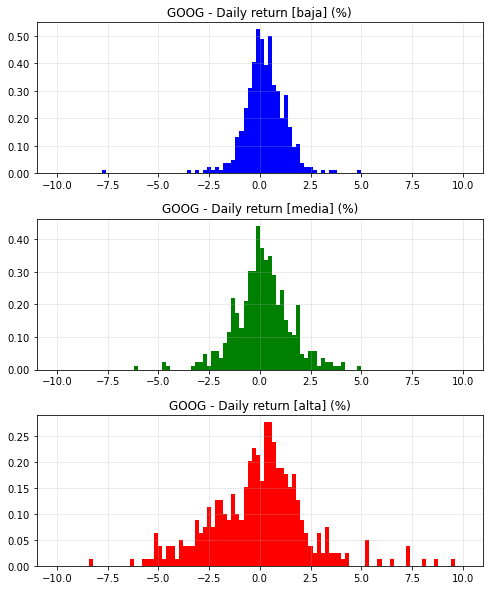

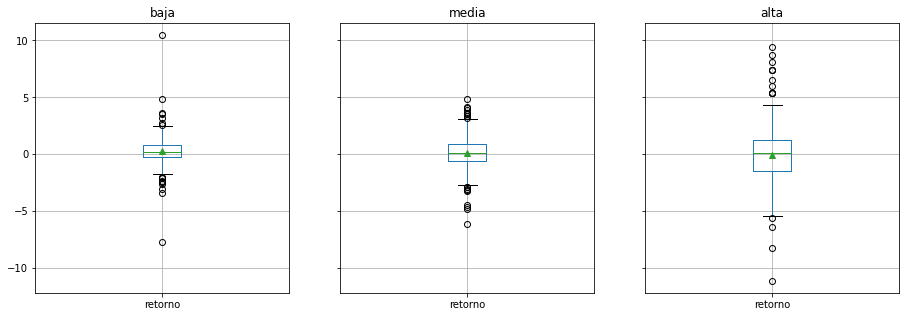

In [42]:
# PLOT 

fig, axs = plt.subplots(3, figsize=(8,10))
extremos=(-10,10)

axs[0].title.set_text(ticker + ' - Daily return [baja] (%)')
axs[0].hist(df_retorno.loc[df_retorno.vix_rango == 'baja'].retorno,bins=100,range=extremos,density=True,color='b')
axs[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[0].grid('True',alpha=0.3)

axs[1].title.set_text(ticker + ' - Daily return [media] (%)')
axs[1].hist(df_retorno.loc[df_retorno.vix_rango == 'media'].retorno,bins=100,range=extremos,density=True,color='g')
axs[1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[1].grid('True',alpha=0.3)

axs[2].title.set_text(ticker + ' - Daily return [alta] (%)')
axs[2].hist(df_retorno.loc[df_retorno.vix_rango == 'alta'].retorno,bins=100,range=extremos,density=True,color='r')
axs[2].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[2].grid('True',alpha=0.3)

fig.subplots_adjust(hspace=0.3)

pd.plotting.boxplot_frame_groupby(df_retorno.groupby('vix_rango'),figsize=(15,5),layout=(1,3),showmeans=True)
plt.show()

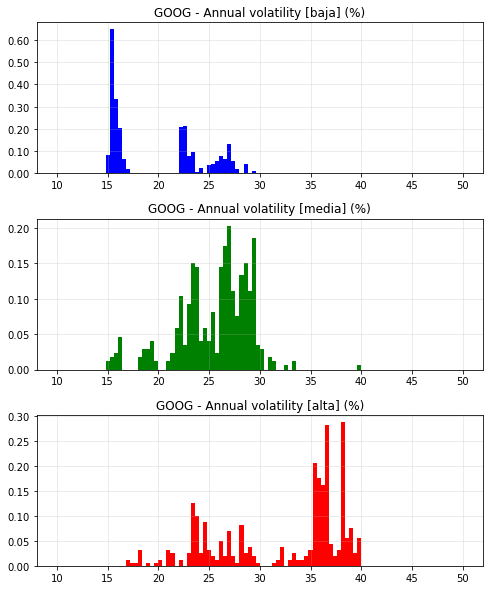

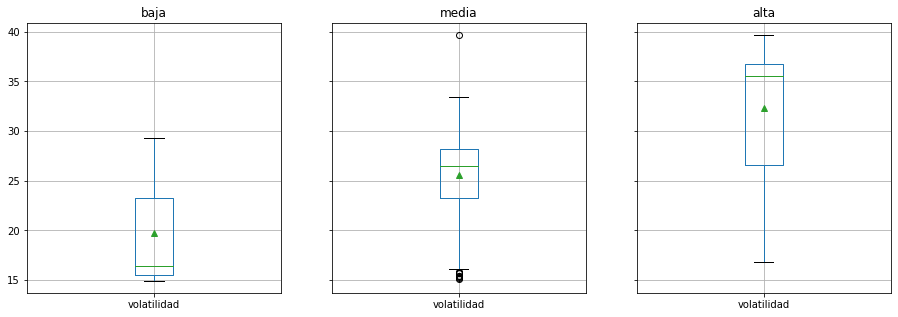

In [43]:
# PLOT 

fig, axs = plt.subplots(3, figsize=(8,10))
extremos=(10,50)

axs[0].title.set_text(ticker + ' - Annual volatility [baja] (%)')
axs[0].hist(df_volatilidad.loc[df_volatilidad.vix_rango == 'baja'].volatilidad,bins=100,range=extremos,density=True,color='b')
axs[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[0].grid('True',alpha=0.3)

axs[1].title.set_text(ticker + ' - Annual volatility [media] (%)')
axs[1].hist(df_volatilidad.loc[df_volatilidad.vix_rango == 'media'].volatilidad,bins=100,range=extremos,density=True,color='g')
axs[1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[1].grid('True',alpha=0.3)

axs[2].title.set_text(ticker + ' - Annual volatility [alta] (%)')
axs[2].hist(df_volatilidad.loc[df_volatilidad.vix_rango == 'alta'].volatilidad,bins=100,range=extremos,density=True,color='r')
axs[2].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[2].grid('True',alpha=0.3)

fig.subplots_adjust(hspace=0.3)

pd.plotting.boxplot_frame_groupby(df_volatilidad.groupby('vix_rango'),figsize=(15,5),layout=(1,3),showmeans=True)
plt.show()

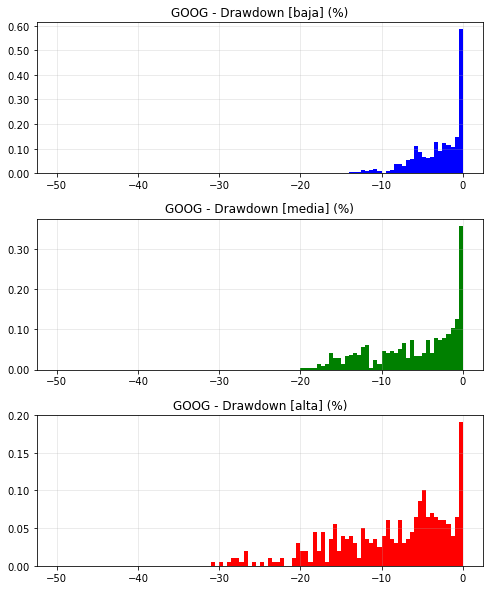

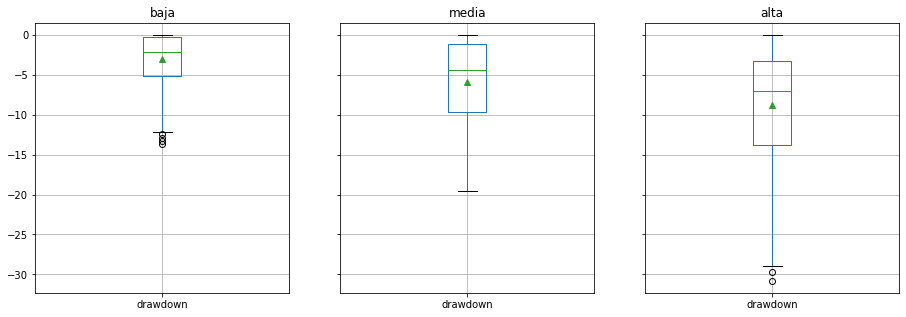

In [44]:
# PLOT 

fig, axs = plt.subplots(3, figsize=(8,10))
extremos=(-50,0)

axs[0].title.set_text(ticker + ' - Drawdown [baja] (%)')
axs[0].hist(df_drawdown.loc[df_drawdown.vix_rango == 'baja'].drawdown,bins=100,range=extremos,density=True,color='b')
axs[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[0].grid('True',alpha=0.3)

axs[1].title.set_text(ticker + ' - Drawdown [media] (%)')
axs[1].hist(df_drawdown.loc[df_drawdown.vix_rango == 'media'].drawdown,bins=100,range=extremos,density=True,color='g')
axs[1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[1].grid('True',alpha=0.3)

axs[2].title.set_text(ticker + ' - Drawdown [alta] (%)')
axs[2].hist(df_drawdown.loc[df_drawdown.vix_rango == 'alta'].drawdown,bins=100,range=extremos,density=True,color='r')
axs[2].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
axs[2].grid('True',alpha=0.3)

fig.subplots_adjust(hspace=0.3)
pd.plotting.boxplot_frame_groupby(df_drawdown.groupby('vix_rango'),figsize=(15,5),layout=(1,3),showmeans=True)
plt.show()

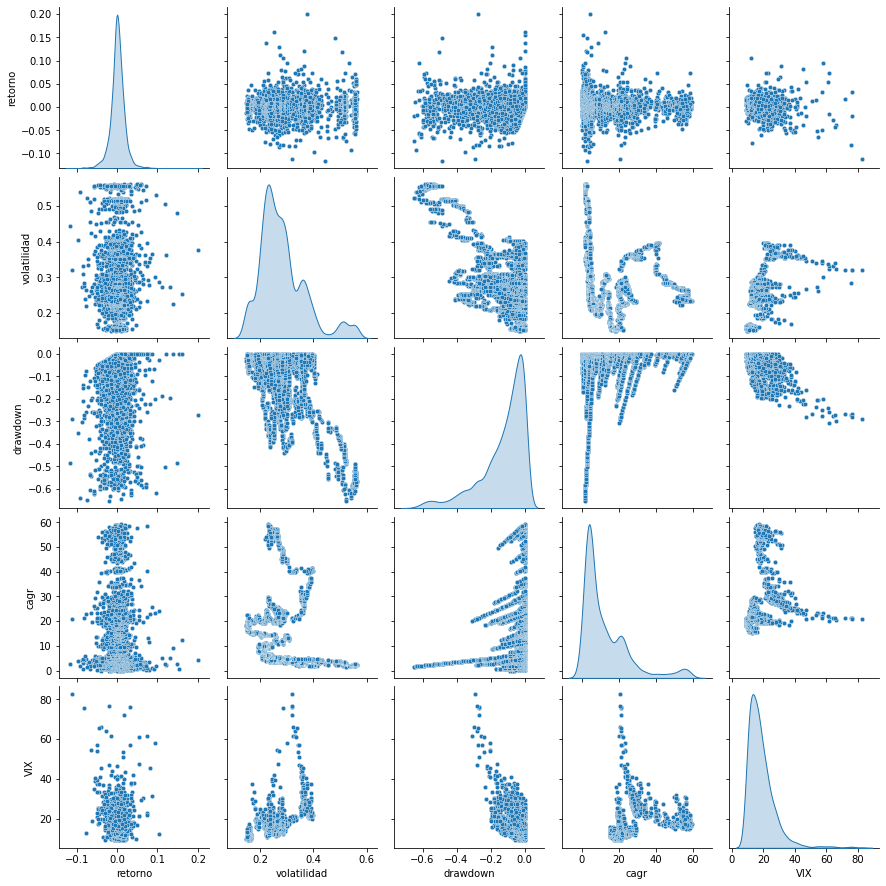

In [45]:
sns.pairplot(df_total,vars=['retorno','volatilidad','drawdown','cagr','VIX'],diag_kind='kde',plot_kws={'s':20})

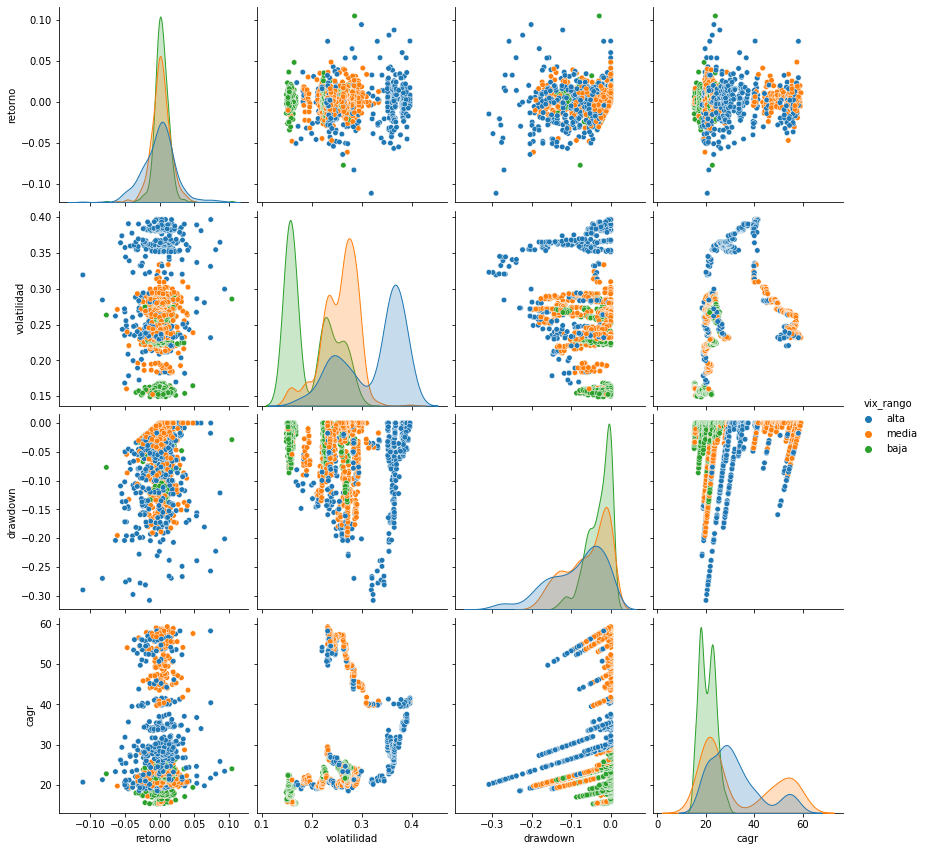

In [46]:
sns.pairplot(df_total,vars=['retorno','volatilidad','drawdown','cagr'],diag_kind='kde',hue='vix_rango',hue_order = ['alta','media','baja'],height=3,plot_kws={'s':30})

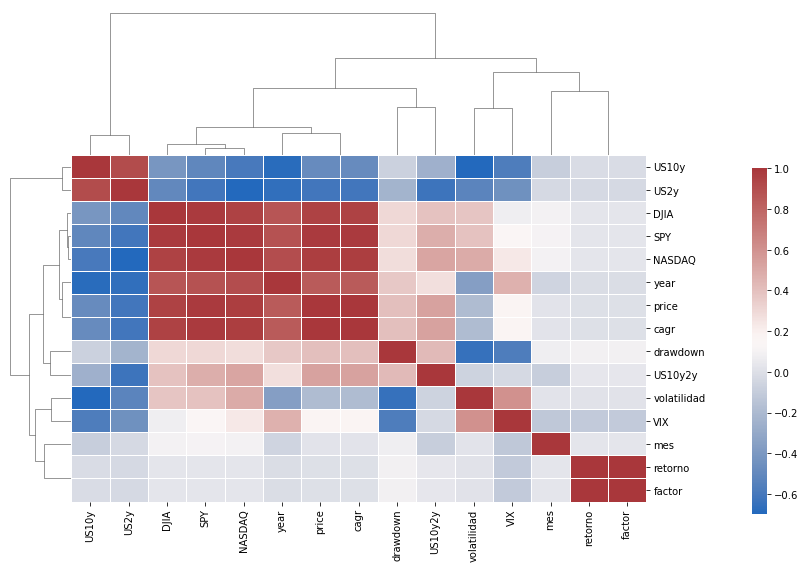

In [47]:
sns.clustermap(df_total.corr(),cmap='vlag',dendrogram_ratio=(.1,.3),cbar_pos=(1.05,.1,.02,.6),linewidths=1,figsize=(10,8))

Text(0.5, 1.0, 'Features Correlating')

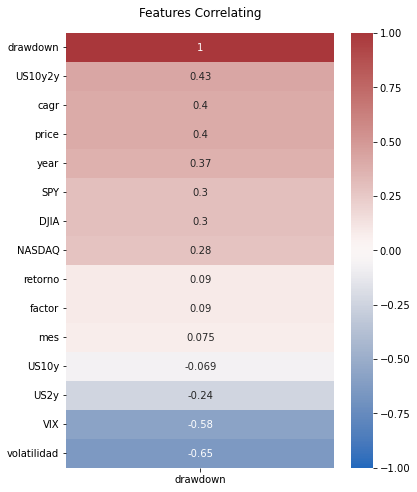

In [48]:
plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(df_total.corr()[['drawdown']].sort_values(by='drawdown', ascending=False), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Features Correlating', fontdict={'fontsize':12}, pad=16)

### Clusterizacion

In [24]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [19]:
def define_y(a=1):
    """
    Valores: 1(retorno) 2(volatilidad) 3(drawdown) 4(cagr)
    """
    if a==1:
        data_y=df_total['retorno']
        label_y='retorno'
    elif a==2:
        data_y=df_total['volatilidad']
        label_y='volatilidad'
    elif a==3:
        data_y=df_total['drawdown']
        label_y='drawdown'
    elif a==4:
        data_y=df_total['cagr']
        label_y='cagr'
    else:
        print('defina variable y')
        data_y=np.nan
        label_y=' '
    
    return data_y,label_y

In [20]:
def define_x(a=1):
    """
    Valores: 1(VIX) 2(US2y) 3(US10y) 4(US10y2y)
    """
    if a==1:
        data_x=df_total['VIX']
        label_x='VIX'
    elif a==2:
        data_x=df_total['US2y']
        label_x='US2y'
    elif a==3:
        data_x=df_total['US10y']
        label_x='US10y'
    elif a==4:
        data_x=df_total['US10y2y']
        label_x='US10y2y'
    else:
        print('defina variable x')
        data_x=np.nan
        label_x=' '
    
    return data_x,label_x

In [25]:
# Define variables de interes

df_total=pd.concat([stock,macro],axis=1)
data_y, label_y=define_y(3)
data_x, label_x=define_x(2)

In [26]:
arr = pd.concat([data_x,data_y],axis=1).dropna().to_numpy()
arr_esc = StandardScaler().fit_transform(arr)

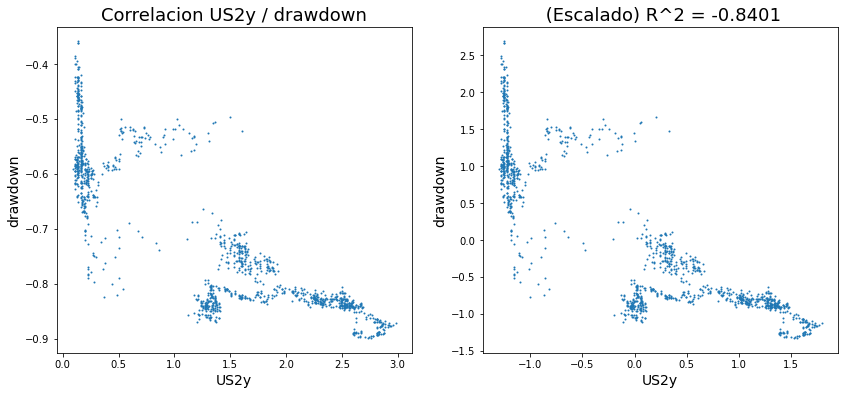

In [27]:
fig, ax = plt.subplots(figsize=(14,6), ncols=2)
r2 = data_x.corr(data_y).round(4)

titulo = 'Correlacion ' + data_x.name + ' / ' + data_y.name
ax[0].scatter(arr[:,0],arr[:,1], s=1) #scatter(x,y, s=1)
ax[0].set_title(titulo, fontsize=18)
ax[0].set_xlabel(data_x.name, fontsize=14)
ax[0].set_ylabel(data_y.name, fontsize=14)

titulo  = ' (Escalado) R^2 = ' + str(r2)
ax[1].scatter(arr_esc[:,0],arr_esc[:,1], s=1)
ax[1].set_title(titulo, fontsize=18)
ax[1].set_xlabel(data_x.name, fontsize=14)
ax[1].set_ylabel(data_y.name, fontsize=14)

plt.show()

### Hierarchy 

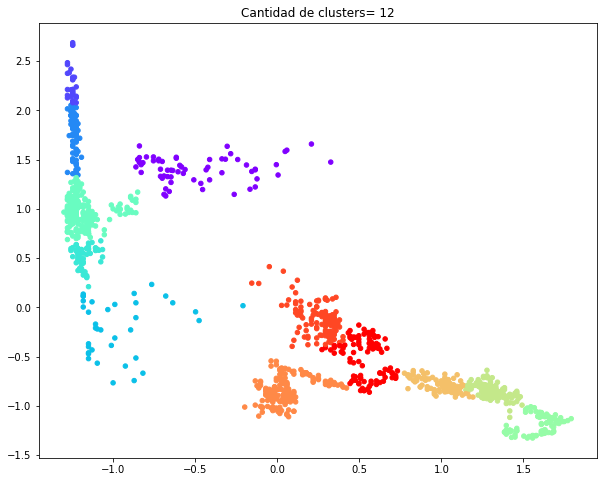

In [28]:
agrupados = linkage(arr_esc, 'ward', metric='euclidean') # single - complete - average - centroid - ward 
clusters = fcluster(agrupados, t=3, criterion='distance')
fig, ax = plt.subplots(figsize=(10,8), nrows=1)
ax.scatter(arr_esc[:,0],arr_esc[:,1], s=20, c=clusters,cmap='rainbow')
ax.set_title('Cantidad de clusters= '+ np.array2string(clusters.max()), fontsize=12)
plt.show()

### K Means

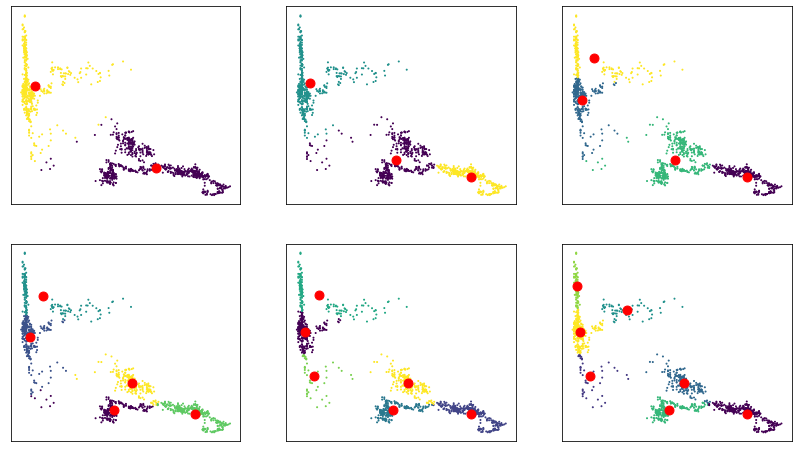

In [29]:
filas = 2
columnas = 3
fig, ax = plt.subplots(figsize=(14,8), nrows=filas, ncols=columnas)

for i in range (filas*columnas):
    col = i % columnas
    row = i // columnas
    modelo = KMeans(n_clusters = i+2)
    y_means = modelo.fit_predict(arr_esc)
    centroides = modelo.cluster_centers_
    ax[row][col].scatter(arr_esc[:,0], arr_esc[:,1], s=1, c=y_means)
    ax[row][col].scatter(centroides[:,0], centroides[:,1], s=80, color='r')
    ax[row][col].axes.xaxis.set_visible(False)
    ax[row][col].axes.yaxis.set_visible(False)
    #ax[row][col].text(s = 'n='+str(i+2), fontsize=20, y=0, x=6)

plt.show()

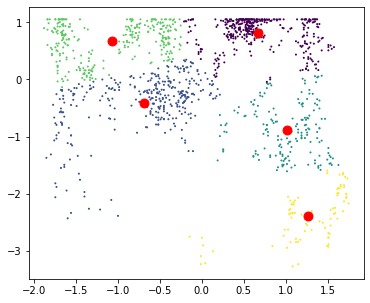

In [70]:
n = 5
modelo = KMeans(n_clusters = n).fit(arr_esc)
y_means = modelo.fit_predict(arr_esc)
centroides = modelo.cluster_centers_

fig, ax = plt.subplots(figsize=(6,5), nrows=1)
ax.scatter(arr_esc[:,0], arr_esc[:,1], s=1, c=y_means)
ax.scatter(centroides[:,0], centroides[:,1], s=80, color='r')

### Gaussian Mixture

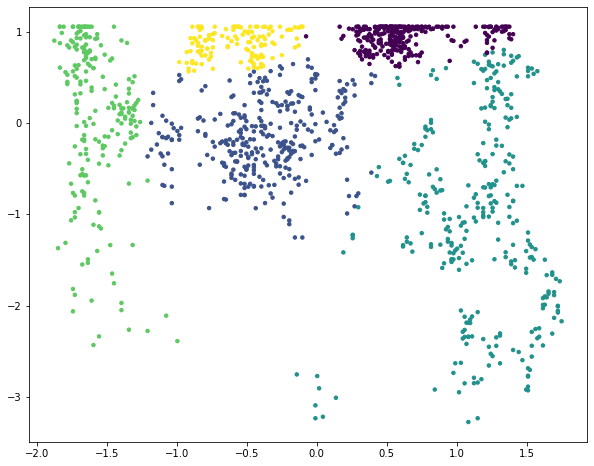

In [71]:
n=5
modelo = GaussianMixture(n_components=n, covariance_type='full').fit(arr_esc)
y_means = modelo.predict(arr_esc)

fig, ax = plt.subplots(figsize=(10,8), nrows=1)
ax.scatter(arr_esc[:,0], arr_esc[:,1], s=12, c=y_means)

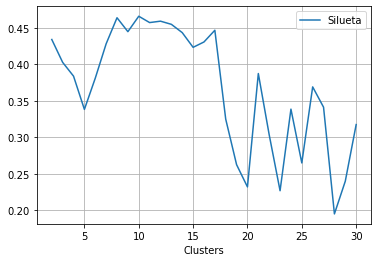

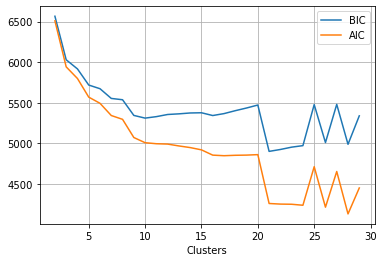

In [72]:
fig, ax = plt.subplots(figsize=(6,4), nrows=1)

pruebas = 30
modelos = [GaussianMixture(n_components=n, covariance_type='full').fit(arr_esc)  for n in range(2,pruebas+1)]

labels = [m.predict(arr_esc) for m in modelos]
siluetas = [silhouette_score(arr_esc, m.predict(arr_esc)) for m in modelos]
ax.plot(range(2,pruebas+1), siluetas, label='Silueta')
ax.legend()
ax.set_xlabel('Clusters')
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(6,4))

pruebas = np.arange(2, 30)
modelos = [GaussianMixture(n, covariance_type='full', random_state=0).fit(arr_esc) for n in pruebas]
ax.plot(pruebas, [m.bic(arr_esc) for m in modelos], label='BIC')
ax.plot(pruebas, [m.aic(arr_esc) for m in modelos], label='AIC')
ax.legend(loc='best')
ax.set_xlabel('Clusters')
ax.grid()
plt.show()

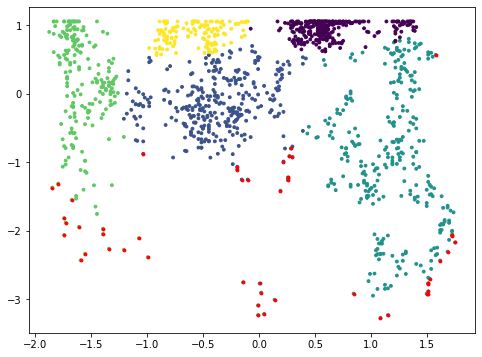

In [73]:
densities = modelo.score_samples(arr_esc)
density_threshold = np.percentile(densities, 4) # 4% de las instancias se catalogan como outliers
anomalies = arr_esc[densities < density_threshold]
fig, ax = plt.subplots(figsize=(8,6), nrows=1)
ax.scatter(arr_esc[:,0], arr_esc[:,1], s=8, c=y_means)
ax.scatter(anomalies[:,0], anomalies[:,1], s=8,color='r')

In [74]:
# Calcula el numero de clusters optimos observando los pesos
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=30, n_init=10, random_state=42)
bgm.fit(arr_esc)
np.round(bgm.weights_, 2)

array([0.21, 0.18, 0.  , 0.  , 0.06, 0.18, 0.  , 0.  , 0.  , 0.08, 0.13,
       0.  , 0.  , 0.01, 0.12, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### DBSCAN

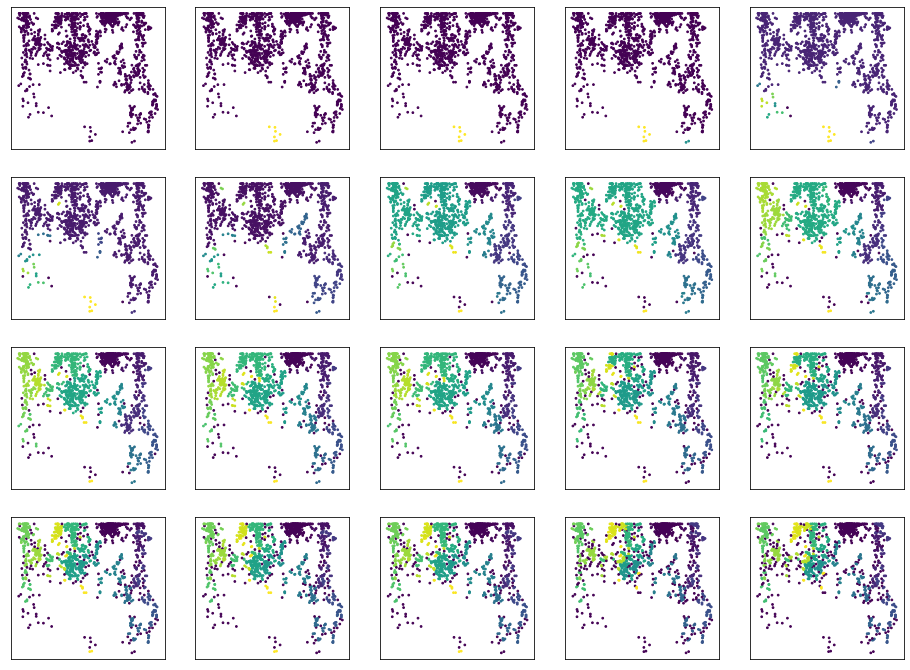

In [75]:
filas = 4
columnas = 5
fig, ax = plt.subplots(figsize=(16,12), nrows=filas, ncols=columnas)

for i in range (filas*columnas):
    col = i % columnas
    row = i // columnas
    
    tolerancia = round(1/(i+1),2)
    modelo = DBSCAN(eps = tolerancia, min_samples=2).fit(arr_esc) 
    y_means = modelo.fit_predict(arr_esc)
    ax[row][col].scatter(arr_esc[:,0], arr_esc[:,1], s=3, c=y_means)
    ax[row][col].axes.xaxis.set_visible(False)
    ax[row][col].axes.yaxis.set_visible(False)
    #ax[row][col].text(s = 'eps='+str(tolerancia), fontsize=8, y=-0.5, x=6)
    

plt.show()

Con epsilon=1.0 hay un solo cluster


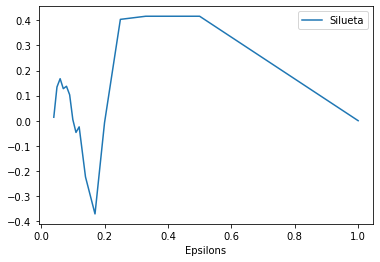

In [76]:
fig, ax = plt.subplots(figsize=(6,4), nrows=1)

pruebas = 25
siluetas = []
epsilons = []
for n in range(pruebas):
    epsilon = round(1/(n+1),2)
    epsilons.append(epsilon)
    try:
        m = DBSCAN(eps = epsilon, min_samples=2).fit(arr_esc)
        siluetas.append(silhouette_score(arr_esc, m.labels_))
    except:
        print(f'Con epsilon={epsilon} hay un solo cluster')
        siluetas.append(0)

    
ax.plot(epsilons, siluetas, label='Silueta')
ax.legend()
ax.set_xlabel('Epsilons')
plt.show()

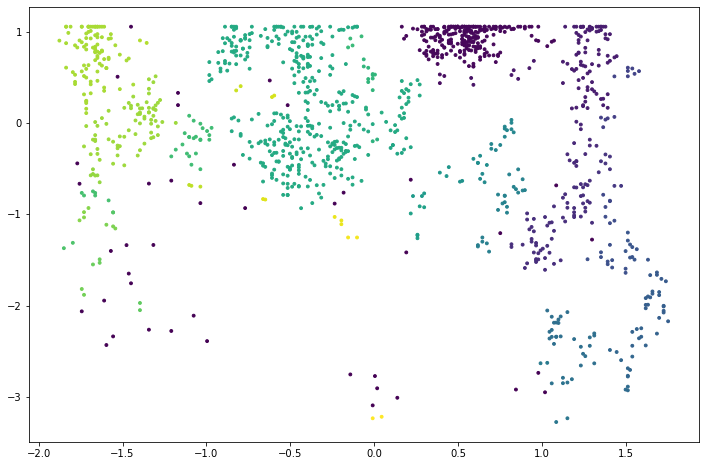

In [77]:
modelo = DBSCAN(eps = 0.1, min_samples=2).fit(arr_esc) 
y_means = modelo.fit_predict(arr_esc)
fig, ax = plt.subplots(figsize=(12,8), nrows=1)
ax.scatter(arr_esc[:,0], arr_esc[:,1], s=8, c=y_means)

### Final de Clustering

In [73]:
# Define variables de interes

df_total=pd.concat([stock,macro],axis=1)
data_y, label_y=define_y(2)
data_x, label_x=define_x(3)
print(label_y,label_x)

volatilidad US10y


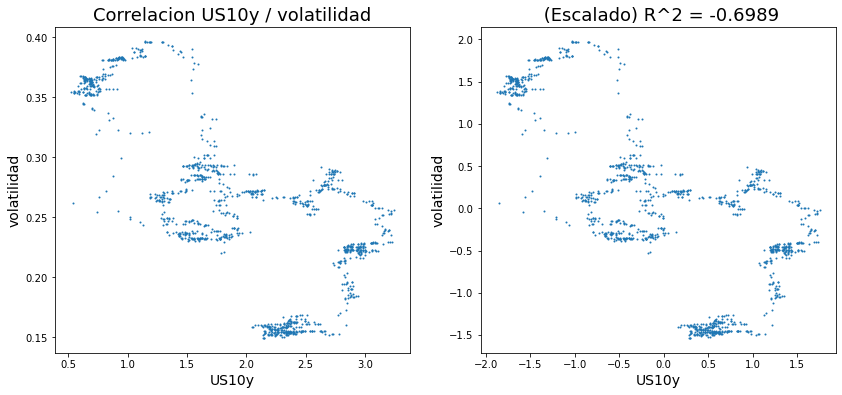

In [74]:
arr = pd.concat([data_x,data_y],axis=1).dropna().to_numpy()
arr_esc = StandardScaler().fit_transform(arr)

fig, ax = plt.subplots(figsize=(14,6), ncols=2)
r2 = data_x.corr(data_y).round(4)

titulo = 'Correlacion ' + data_x.name + ' / ' + data_y.name
ax[0].scatter(arr[:,0],arr[:,1], s=1) #scatter(x,y, s=1)
ax[0].set_title(titulo, fontsize=18)
ax[0].set_xlabel(data_x.name, fontsize=14)
ax[0].set_ylabel(data_y.name, fontsize=14)

titulo  = ' (Escalado) R^2 = ' + str(r2)
ax[1].scatter(arr_esc[:,0],arr_esc[:,1], s=1)
ax[1].set_title(titulo, fontsize=18)
ax[1].set_xlabel(data_x.name, fontsize=14)
ax[1].set_ylabel(data_y.name, fontsize=14)

plt.show()

In [75]:
#r2 = data_x.corr(data_y).round(4)

arr = pd.concat([data_x,data_y],axis=1).dropna()
arr_esc = StandardScaler().fit_transform(arr)

arr=arr.reset_index()
arr.rename(columns={'index':'fecha'},inplace=True)

n=3

modelo = KMeans(n_clusters = n).fit(arr_esc)
y_means = modelo.fit_predict(arr_esc)
centroides = modelo.cluster_centers_ 

clustersList = list(y_means)
for i in range(len(arr)):
    arr.loc[i,'cluster'] = clustersList.pop()

In [76]:
# SOLO lo utilizo para validar plots scaled/no scaled estan bien

#colores= ["orange","green","brown","cyan","magenta","blue","red","yellow","lightgreen","pink"]  
#plt.figure(figsize=(6,4))

#for c in range(n):
        
#    df_total = arr.loc[arr.cluster == c]
#    co = round(df_total[label_x].corr(df_total[label_y]),2)

#    plt.scatter(arr_esc[y_means == c,0],arr_esc[y_means == c,1],s=5, color=colores[c], cmap='rainbow')
#    coords = (centroides[c,0]*0.9, centroides[c,1])
#    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
#    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


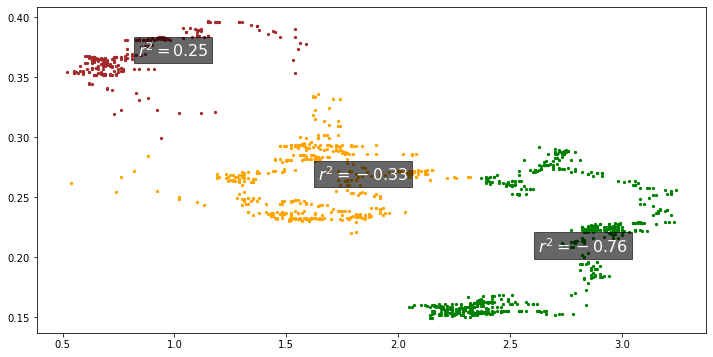

In [77]:
colores= ["orange","green","brown","cyan","magenta","blue","red","yellow","lightgreen","pink"]  
plt.figure(figsize=(12,6))

for c in range(n):
        
    df_total = arr.loc[arr.cluster == c]
    co = round(df_total[label_x].corr(df_total[label_y]),2)

    plt.scatter(arr.loc[y_means == c][label_x],arr.loc[y_means == c][label_y],s=5, color=colores[c], cmap='rainbow')
            
    coords = (arr.loc[y_means==c][label_x].mean(), arr.loc[y_means==c][label_y].mean())
    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


In [78]:
modelo = GaussianMixture(n_components=n, covariance_type='full').fit(arr_esc)
y_means = modelo.predict(arr_esc)

clustersList = list(y_means)
for i in range(len(arr)):
    arr.loc[i,'cluster'] = clustersList.pop()

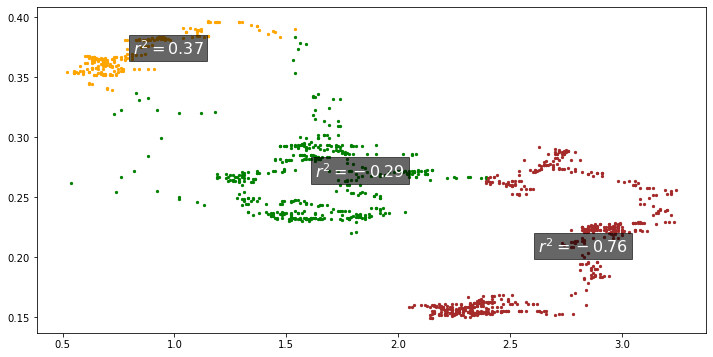

In [79]:
plt.figure(figsize=(12,6))

for c in range(n):
        
    df_total = arr.loc[arr.cluster == c]
    co = round(df_total[label_x].corr(df_total[label_y]),2)

    plt.scatter(arr.loc[y_means == c][label_x],arr.loc[y_means == c][label_y],s=5, color=colores[c], cmap='rainbow')
            
    coords = (arr.loc[y_means==c][label_x].mean(), arr.loc[y_means==c][label_y].mean())
    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


In [82]:
modelo = DBSCAN(eps = 0.2, min_samples=2).fit(arr_esc) 
y_means = modelo.fit_predict(arr_esc)

clustersList = list(y_means)
for i in range(len(arr)):
    arr.loc[i,'cluster'] = clustersList.pop()

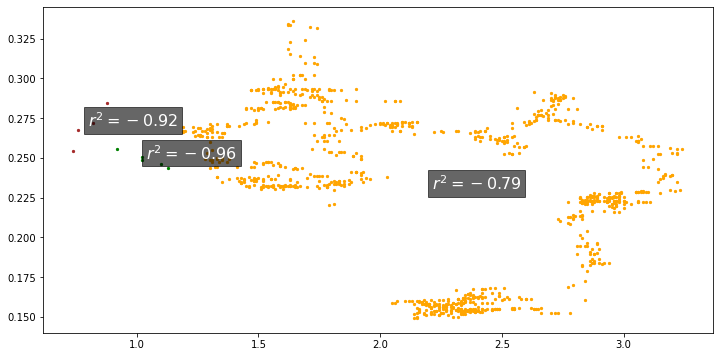

In [83]:
plt.figure(figsize=(12,6))

for c in range(n):
        
    df_total = arr.loc[arr.cluster == c]
    co = round(df_total[label_x].corr(df_total[label_y]),2)

    #plt.scatter(arr_esc[y_means == c,0],arr_esc[y_means == c,1],s=5, color=colores[c], cmap='rainbow')
    plt.scatter(arr.loc[y_means == c][label_x],arr.loc[y_means == c][label_y],s=5, color=colores[c], cmap='rainbow')
            
    coords = (arr.loc[y_means==c][label_x].mean(), arr.loc[y_means==c][label_y].mean())
    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


****
## DIMENSION TECNICA

In [37]:
def getPrice(symbol):
    """
    Historical Daily Prices
    Dado un activo (symbol), retorna unicamente su closing price historico (máx 40 years)
    Return: daily dataframe (close)
    """        
    url='https://financialmodelingprep.com/api/v3/historical-price-full/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p= {'serietype' : 'line','apikey': api_key}
    r=requests.get(url,params=p)
    js=r.json()
    df=pd.DataFrame(js['historical'])
    df.set_index('date',inplace=True)
    df.index=pd.to_datetime(df.index)
    df.rename(columns={'close':'price'},inplace=True)
    df.sort_values('date',ascending=True, inplace=True)
    return df

In [38]:
def getPriceVolume(symbol):
    """
    Historical Daily Prices with change and volume
    Dado un activo (symbol), retorna unicamente su closing price historico (máx 10 years)
    Return: daily dataframe (close)
    """        
    url='https://financialmodelingprep.com/api/v3/historical-price-full/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p= {'apikey': api_key}
    r=requests.get(url,params=p)
    js=r.json()
    df=pd.DataFrame(js['historical'])
    df.set_index('date',inplace=True)
    df.index=pd.to_datetime(df.index)
    df.rename(columns={'adjClose':'price'},inplace=True)
    df.sort_values('date',ascending=True, inplace=True)
    return df

In [39]:
def getQuote(symbol):
    """
    Company Quote


    """
    url='https://financialmodelingprep.com/api/v3/quote/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    df=pd.DataFrame(js)
    return df

In [40]:
historia=getPrice(ticker)
reciente=getPriceVolume(ticker)
quote=getQuote(ticker)

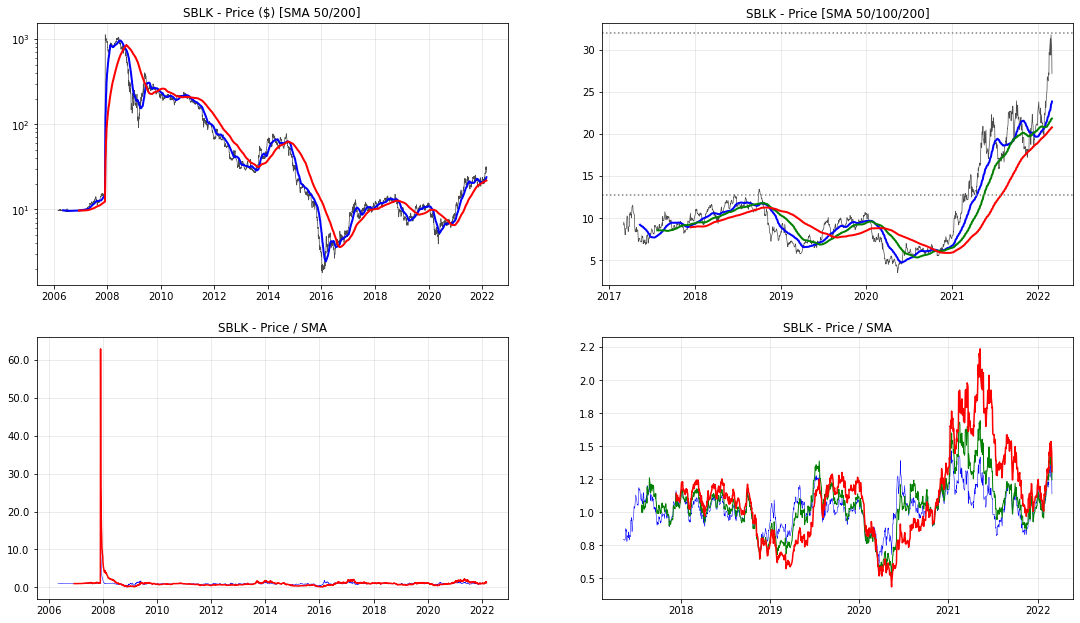

In [41]:
# PLOT PANEL GENERAL

fig,ax =plt.subplots(figsize=(16,8),nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.2,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - Price ($) [SMA 50/200]')
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][0].set_yscale('log')
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(historia.price,'k-',lw=0.7,alpha=0.7)
ax[0][0].plot(historia.price.rolling(50).mean(),'b-',lw=2)
ax[0][0].plot(historia.price.rolling(200).mean(),'r-',lw=2)

ax[1][0].title.set_text(ticker + ' - Price / SMA')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(historia.price/historia.price.rolling(50).mean(),'b-',lw=0.5)
ax[1][0].plot(historia.price/historia.price.rolling(200).mean(),'r-',lw=1.5)

ax[0][1].title.set_text(ticker + ' - Price [SMA 50/100/200]')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][1].grid('True',alpha=0.3)
#ax[0][1].plot(reciente.price,'k',ls='',marker='o',ms=4,lw=0.7,alpha=0.7)
ax[0][1].plot(reciente.price,'k-',lw=0.7,alpha=0.7)
ax[0][1].plot(reciente.price.rolling(50).mean(),'b-',lw=2)
ax[0][1].plot(reciente.price.rolling(100).mean(),'g-',lw=2)
ax[0][1].plot(reciente.price.rolling(200).mean(),'r-',lw=2)
ax[0][1].axhline(quote.yearHigh.mean(),ls='dotted',color='grey')
ax[0][1].axhline(quote.yearLow.mean(),ls='dotted',color='grey')

ax[1][1].title.set_text(ticker + ' - Price / SMA')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(reciente.price/reciente.price.rolling(50).mean(),'b-',lw=0.5)
ax[1][1].plot(reciente.price/reciente.price.rolling(100).mean(),'g-',lw=1)
ax[1][1].plot(reciente.price/reciente.price.rolling(200).mean(),'r-',lw=1.5)

****
## DIMENSION FUNDAMENTAL

In [104]:
# P/E average by sector (financial modeling)

In [19]:
def getHolders(symbol):
    """
    Error Message: Special Endpoint : this endpoint is only for premium members
    """

    url='https://financialmodelingprep.com/api/v3/institutional-holder/'+symbol
    url='https://financialmodelingprep.com/api/v3/mutual-fund-holder/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
      
    return df

In [20]:
def getInsiders(symbol):
    """
    Error Message: Special Endpoint : this endpoint is only for premium members
    """

    url='https://financialmodelingprep.com/api/v3/insider-trading/'+symbol
        
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'limit':100,'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
      
    return df

In [21]:
def getPeers(symbol):
    """
    Error Message: Special Endpoint : this endpoint is only for premium members
    """

    url='https://financialmodelingprep.com/api/v4/stock_peers/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    peers=peers[0]['peersList']
    #df = pd.DataFrame(js)
    return peers

In [22]:
def getProfile(symbol):

    url='https://financialmodelingprep.com/api/v3/profile/'+symbol
    
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    return df

In [23]:
def getKeyMetrics(symbol,period='annual'):

    try:
   
        url='https://financialmodelingprep.com/api/v3/key-metrics/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p = {'apikey': api_key,'period':period}
        r = requests.get(url, params = p)
        js = r.json()
        df = pd.DataFrame(js)
        df=df.set_index('date')
        df=df.drop(['symbol'],axis=1)
        #df.index=pd.to_datetime(df.index)
        df=df.loc[::-1]
        return df
    
    except:
        print(symbol + ' Key Metrics not found')


In [24]:
def getIncomeStatement(symbol,period='annual'):

    try:
        
        url='https://financialmodelingprep.com/api/v3/income-statement/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p = {'apikey': api_key,'period':period}
        r = requests.get(url, params = p)
        js = r.json()
        df = pd.DataFrame(js)
        df=df.set_index('date')
        df=df.drop(['symbol'],axis=1)
        #df.index=pd.to_datetime(df.index)
        df=df.loc[::-1]
        return df

    except:
        print(symbol + ' Income Statement not found')


In [25]:
def getIncomeStatementGrowth(symbol,period='annual'):

    try:
               
        url='https://financialmodelingprep.com/api/v3/income-statement-growth/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p = {'apikey': api_key,'period':period}
        r = requests.get(url, params = p)
        js = r.json()
        df = pd.DataFrame(js)
        df=df.set_index('date')
        df=df.drop(['symbol'],axis=1)
        #df.index=pd.to_datetime(df.index)
        df=df.loc[::-1]
        return df

    except:
        print(symbol + ' Income Statement Growth not found')

In [26]:
def get_all(ticker,period='annual'):
    
    profile=getProfile(ticker)
    key_metrics=getKeyMetrics(ticker,period)
    income_state=getIncomeStatement(ticker,period)
    income_growth=getIncomeStatementGrowth(ticker,period)

    return profile,key_metrics,income_state,income_growth

In [27]:
def getTTM(symbol):
    url='https://financialmodelingprep.com/api/v3/ratios-ttm/'+symbol
    api_key='bb2325e9fc32528d8472b3d75d1bd41c'
    p = {'apikey': api_key}
    r = requests.get(url, params = p)
    js = r.json()
    return js

In [107]:
# https://codingandfun.com/profitability-analysis-with-python/

#profitability_ratios={}
#peers=['CVS','AAPL','FB','NVDA','ADBE','CSCO']

In [108]:
#for stock in peers:
#    profitability_ratios[stock]={}
#    profitability_ratios[stock]['Return on Assets']=getTTM(stock)[0]['returnOnAssetsTTM']
#    profitability_ratios[stock]['Return on Equity']=getTTM(stock)[0]['returnOnEquityTTM']
#    profitability_ratios[stock]['Gross Profit Margin']=getTTM(stock)[0]['grossProfitMarginTTM']
#    profitability_ratios[stock]['Operating Profit Margin']=getTTM(stock)[0]['operatingProfitMarginTTM']
#    profitability_ratios[stock]['Net Profit Margin']=getTTM(stock)[0]['netProfitMarginTTM']
    
#profitability_ratios=pd.DataFrame(profitability_ratios)
#print(profitability_ratios)

In [109]:
 #portfolio=['EDU','ITB','ROM','BIB','KRE','CHIX','KWEB','OIH','SU','FXI','KSTR']
 #for ticker in portfolio:
 #    profile,key_metrics,income_state,income_growth=get_all(ticker)

In [43]:
#ticker='PLL'
profile,key_metrics,income_state,income_growth=get_all(ticker)

In [44]:
# PROFILE

texto=['Ticker  ','Company ','Exchange','Sector  ','Industry']
claves = ['symbol','companyName','exchangeShortName','sector','industry']

for i in range(len(claves)):
        
    print('%s %s' % (texto[i],profile[claves[i]].values))

print('\nPrice            ($) {:1.1f}'.format(float(profile.price)))
print('Graham number    ( ) {:1}'.format(int(key_metrics.grahamNumber.iloc[-1])))
print('Beta             ( ) {:1.1f}'.format(float(profile.beta)))
print('Average Volume ($MM) {:1,}'.format(int(profile.price*profile.volAvg/1e6)))
print('Market Cap     ($MM) {:1,}'.format(int(profile.mktCap/1e6)))

Ticker   ['SBLK']
Company  ['Star Bulk Carriers Corp.']
Exchange ['NASDAQ']
Sector   ['Industrials']
Industry ['Marine Shipping']

Price            ($) 29.8
Graham number    ( ) 6
Beta             ( ) 1.0
Average Volume ($MM) 75
Market Cap     ($MM) 3,044


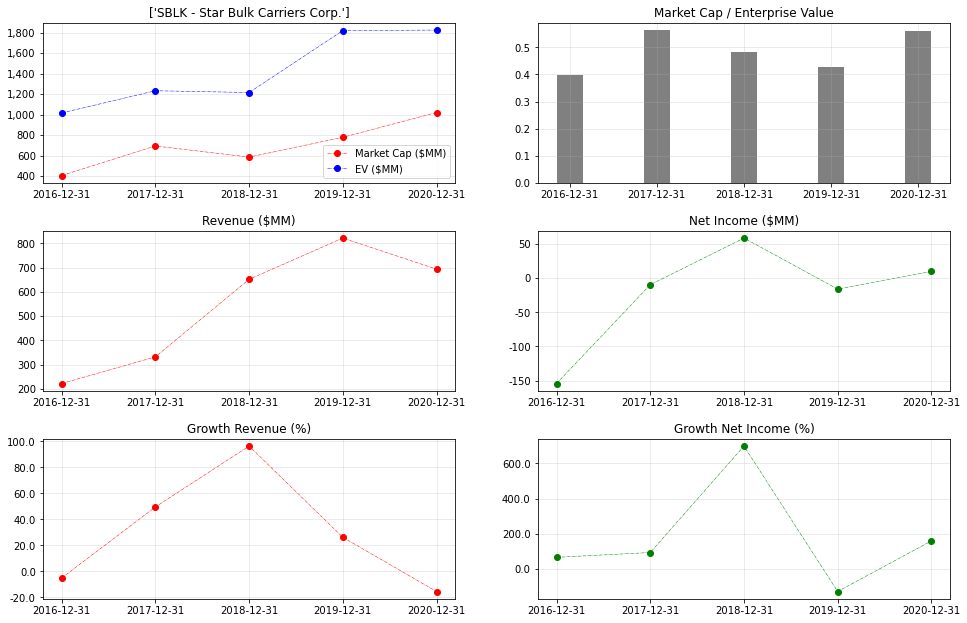

In [45]:
# PLOT 1

fig,ax =plt.subplots(figsize=(14,8),nrows=3,ncols=2)
fig.subplots_adjust(hspace=0.3,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - ' + profile.companyName.values)
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(key_metrics.marketCap/1e6,c='r',ls="-.", lw=0.5,marker='o')
ax[0][0].plot(key_metrics.enterpriseValue/1e6,c='b',ls="-.", lw=0.5,marker='o')
ax[0][0].legend(['Market Cap ($MM)','EV ($MM)'],loc='lower right')

ax[0][1].title.set_text('Market Cap / Enterprise Value')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[0][1].grid('True',alpha=0.3)
ax[0][1].bar(key_metrics.index,key_metrics.marketCap/key_metrics.enterpriseValue,width=0.3,color='gray')

ax[1][0].title.set_text('Revenue ($MM)')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(income_state.revenue/1e6,c='r',ls="-.", lw=0.5,marker='o')

ax[1][1].title.set_text('Net Income ($MM)')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(income_state.netIncome/1e6,c='g',ls="-.", lw=0.5,marker='o')

ax[2][0].title.set_text('Growth Revenue (%)')
ax[2][0].grid('True',alpha=0.3)
ax[2][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[2][0].plot(income_growth.growthRevenue*100,c='r',ls="-.", lw=0.5,marker='o')

ax[2][1].title.set_text('Growth Net Income (%)')
ax[2][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[2][1].grid('True',alpha=0.3)
ax[2][1].plot(income_growth.growthNetIncome*100,c='g',ls="-.", lw=0.5,marker='o')

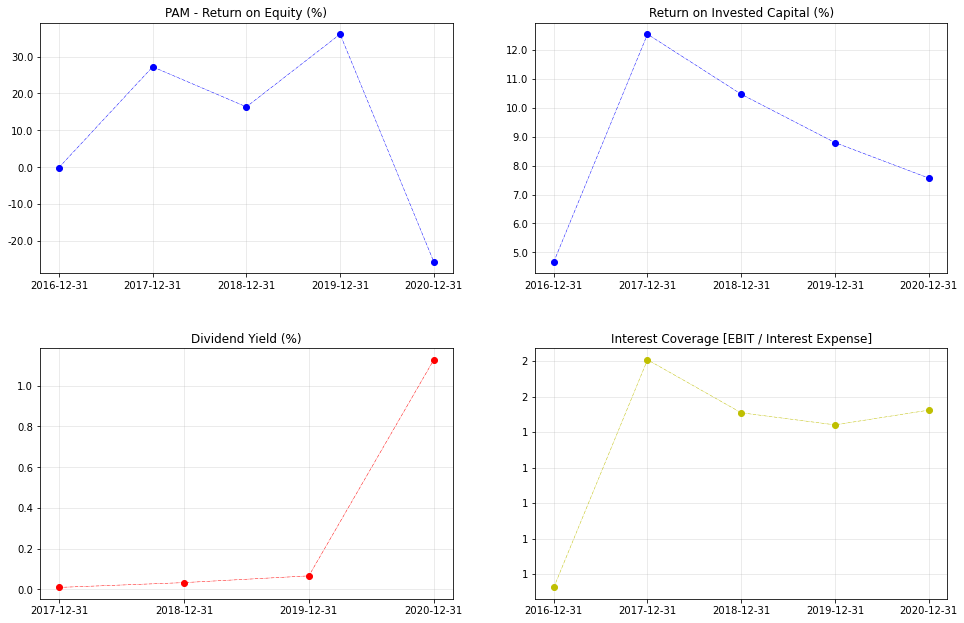

In [31]:
# PLOT 2

fig,ax =plt.subplots(figsize=(14,8),nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - Return on Equity (%)')
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(key_metrics.roe*100,c='b',ls="-.", lw=0.5,marker='o')

ax[0][1].title.set_text('Return on Invested Capital (%)')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[0][1].grid('True',alpha=0.3)
ax[0][1].plot(key_metrics.roic*100,c='b',ls="-.", lw=0.5,marker='o')

ax[1][0].title.set_text('Dividend Yield (%)')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(key_metrics.dividendYield*100,c='r',ls="-.", lw=0.5,marker='o')

ax[1][1].title.set_text('Interest Coverage [EBIT / Interest Expense]')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.0f' % x))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(key_metrics.interestCoverage,c='y',ls="-.", lw=0.5,marker='o')

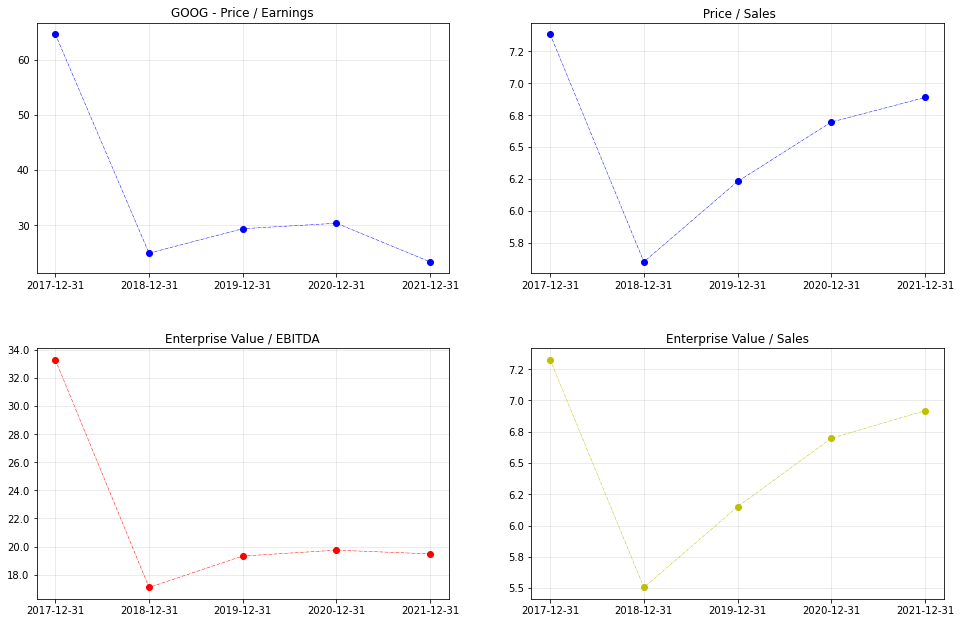

In [114]:
# PLOT 3

fig,ax =plt.subplots(figsize=(14,8),nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text(ticker + ' - Price / Earnings')
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.0f' % x))
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(key_metrics.peRatio,c='b',ls="-.", lw=0.5,marker='o')

ax[0][1].title.set_text(' Price / Sales')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[0][1].grid('True',alpha=0.3)
ax[0][1].plot(key_metrics.priceToSalesRatio,c='b',ls="-.", lw=0.5,marker='o')

ax[1][0].title.set_text('Enterprise Value / EBITDA')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(key_metrics.enterpriseValueOverEBITDA,c='r',ls="-.", lw=0.5,marker='o')

ax[1][1].title.set_text('Enterprise Value / Sales')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.1f' % x))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(key_metrics.evToSales,c='y',ls="-.", lw=0.5,marker='o')

In [125]:
actual_dy=0.0
actual_pe=23
# Historical (reference) - GMO & RA
# PE historico=20
# Earnings Growth historico =7

In [126]:
pe=list(range(10,55,5))
ge=list(range(1,11,1))
rdm = list()
for j in range(len(ge)):
    for i in range(len(pe)):
        valores=actual_dy + ge[j] + ((pe[i]/actual_pe)**0.14-1)*100
        rdm.append(valores)
matriz=np.array(rdm).reshape(len(ge),len(pe))
df=pd.DataFrame(matriz)
df.columns=pe
df.index=ge

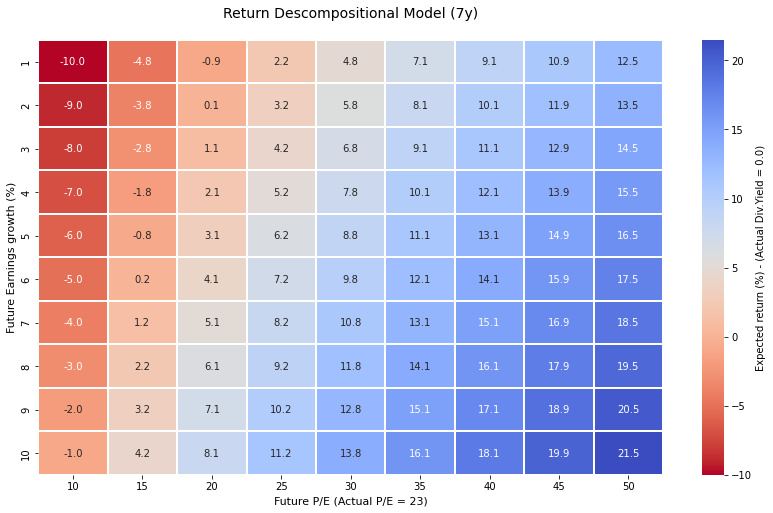

In [127]:
f,ax=plt.subplots(figsize=(14,8))
sns.heatmap(df,annot=True,fmt='.1f',linewidths=.3,cmap='coolwarm_r',ax=ax,cbar_kws={'label': 'Expected return (%)' + ' - (Actual Div.Yield = ' + str(actual_dy) +')'}) 
plt.title('Return Descompositional Model (7y)\n',fontsize = 14) 
plt.xlabel('Future P/E'+ ' (Actual P/E = ' + str(actual_pe) + ')', fontsize = 11) 
plt.ylabel('Future Earnings growth (%)', fontsize = 11)
plt.show()